# Setup

In [237]:
## Setup

# Install Kaggle library
! pip install kaggle &> /dev/null

# Move kaggle.json to ~./kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle 

# Get Sarcasm on Reddit dataset
! kaggle datasets download -d danofer/sarcasm

# Hide Kaggle API key
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
sarcasm.zip: Skipping, found more recently modified local copy (use --force to force download)


In [238]:
# get pyspark
!pip install pyspark

In [239]:
## Unpack Files
! unzip /content/sarcasm.zip

Archive:  /content/sarcasm.zip
replace test-balanced.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test-unbalanced.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train-balanced-sarc.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train-balanced-sarcasm.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [240]:
## Data Processing Imports

import pandas as pd
import pyspark as spark
from pyspark.sql import SparkSession
import time
import pdb

In [241]:
## Start New Spark Session

spark = SparkSession.builder.appName("Sarcasm-BERT").getOrCreate()

In [242]:
## Load Files w/ Pandas

def check_load_time(filepath):

  t1 = time.time()
  _df = pd.read_csv(filepath)
  t2 = time.time()

  print(f"{filepath} takes {round(t2 - t1, 2)} seconds to load.")

  return _df

test_balanced_df = check_load_time("test-balanced.csv")
test_unbalanced_df = check_load_time("test-unbalanced.csv")
train_df = check_load_time("train-balanced-sarcasm.csv")

test-balanced.csv takes 0.06 seconds to load.
test-unbalanced.csv takes 0.39 seconds to load.
train-balanced-sarcasm.csv takes 6.64 seconds to load.


In [243]:
## Checking if dataset is balanced

n_sarcastic = train_df["label"].sum()
n_serious = train_df["label"].count() - n_sarcastic

print(f"Sarcastic comments: {n_sarcastic}\nSerious comments: {n_serious}")

Sarcastic comments: 505413
Serious comments: 505413


In [244]:
## train_df preprocessing
word_threshold = 20
n_entries = 10000

# Select relevant columns
train_df = train_df[["label", "comment"]]

# Drop na columns
train_df = train_df.dropna()

# Drop entries where the text field has fewer than 20 words
train_df = train_df[train_df["comment"].apply(lambda x: len(x.split(" "))) >= word_threshold]

# Get first n_entries, balance sarcastic/serious, alternate entries
train_df_condensed_0 = train_df[train_df["label"] == 0].iloc[: n_entries // 2]
train_df_condensed_0.reset_index(drop = True, inplace = True)
train_df_condensed_1 = train_df[train_df["label"] == 1].iloc[: n_entries // 2]
train_df_condensed_1.reset_index(drop = True, inplace = True)

# Merge, so that entries alternate by label
train_df_condensed = pd.concat([train_df_condensed_0, train_df_condensed_1]).sort_index(kind = "merge")

In [245]:
train_df_condensed.head()

,label,comment
0,0,"I don't pay attention to her, but as long as s..."
0,1,wow it is totally unreasonable to assume that ...
1,0,Conservatism as an ideology is for sure a reac...
1,1,Ho ho ho... But Melania said that there is no ...
2,0,I only watched the first 20 mins bc I fell asl...


In [246]:
train_df_condensed_1.head()

,label,comment
0,1,wow it is totally unreasonable to assume that ...
1,1,Ho ho ho... But Melania said that there is no ...
2,1,"Oh, I never realized it was so easy, why had I..."
3,1,I remember reading all of those stories in the...
4,1,"Yeah, those kids who can't eat peanuts without..."


In [247]:
train_df_condensed_0.head()

,label,comment
0,0,"I don't pay attention to her, but as long as s..."
1,0,Conservatism as an ideology is for sure a reac...
2,0,I only watched the first 20 mins bc I fell asl...
3,0,How I'm considered an asshole because I let pe...
4,0,John Lott is a hack an the only people who giv...


# BERT

Code based on these tutorials: <p> https://luv-bansal.medium.com/fine-tuning-bert-for-text-classification-in-pytorch-503d97342db2, <br> https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [248]:
! pip install transformers &> /dev/null

In [249]:
## Define hyperparameters
n_BATCH = 32
n_EVAL = 32

In [250]:
## Pretrained BERT lives in "transformers"
import transformers

## Other useful imports
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [251]:
## Create dataset from train-balanced-sarcasm

class BertDataset(Dataset):

  def __init__(self, _df, tokenizer, max_length = 100):

    # inherit from Dataset superclass
    super(BertDataset, self).__init__()

    self.train = _df
    self.label = _df["label"]
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.train)

  def __getitem__(self, index):
    '''
    Get text entry at iloc "index" from train dataset.
    '''

    text1 = self.train.iloc[index, 1]

    # Specify parameters for BERT tokenizer
    inputs = self.tokenizer(
        text1,
        None,
        padding = 'max_length',
        add_special_tokens = True,
        return_attention_mask = True,
        max_length = self.max_length
    )

    # unpack ids and mask from tokenized inputs
    ids = inputs["input_ids"]
    token_type_ids = inputs["token_type_ids"]
    mask = inputs["attention_mask"]

    return {
            'ids': torch.tensor(ids, dtype=torch.long)[:100],
            'mask': torch.tensor(mask, dtype=torch.long)[:100],
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)[:100],
            'target': torch.tensor(self.train.iloc[index, 0], dtype=torch.long).unsqueeze(0)[:100]
            }

tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

# Make training dataset, with 0 and 1 labeled datapoints alternating
train_dataset = BertDataset(train_df_condensed, tokenizer)

# Make 0 and 1 only training datasets
train_dataset_0 = BertDataset(train_df_condensed_0, tokenizer)
train_dataset_1 = BertDataset(train_df_condensed_1, tokenizer)

# Initialize dataloaders
dataloader = DataLoader(dataset = train_dataset, batch_size = n_BATCH)
dataloader_0 = DataLoader(dataset = train_dataset_0, batch_size = n_BATCH)
dataloader_1 = DataLoader(dataset = train_dataset_1, batch_size = n_BATCH)

In [252]:
# Define class, based around pytorch nn module and pretrained BERT from transformers

class BERT(nn.Module):

  def __init__(self):
    super(BERT, self).__init__()

    # get pretrained bert from transformers module
    # should look into alternatives to "bert_base_uncased"
    self.model = transformers.BertModel.from_pretrained("bert-base-uncased")

    # linear layers. We will fine tune these for the sarcasm prediction task
    self.hidden = nn.Linear(768, 768)
    self.out = nn.Linear(768, 1)

    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, ids, mask, token_type_ids):
    
    # BERT
    _, _out = self.model(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict = False)

    # hidden layer + ReLU
    #_out = self.hidden(self.hidden(_out))
    # get tanh on [0,1]
    _out = (self.tanh(self.out(_out)) + 1) / 2

    return _out

In [253]:
## Instantiate model, loss, optim 

model = BERT()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

## IMPORTANT: since I'm only looking to train the last layer, I remove requires grad from all BERT params!
## we may want to run a couple epochs on some layers in the net
for param in model.model.parameters():
  param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [254]:
def get_hms(sec):

  h = int(sec // 3600)
  m = int(sec % 3600 // 60)
  s = int(round(sec % 60))

  return h,m,s 

In [255]:
acc_list, fp_list, fn_list, loss_list = [], [], [], []
sample_texts_0, sample_texts_1 = dict(), dict()

In [256]:
# Plot accuracy, loss, fp/fn over training

def update_plots(acc_list, fp_list, fn_list, loss_list, sample_texts_0, sample_texts_1):
  
  # Plot metrics plot
  
  plt.figure(figsize = (12,6))

  plt.title("Metrics")
  plt.xlabel("Batch")
  plt.ylabel("Accuracy, False Positive Rate, False Negative Rate")

  plt.ylim(0,1)

  plt.plot(acc_list, label = "Accuracy")
  plt.plot(fp_list, label = "False Positive Rate")
  plt.plot(fn_list, label = "False Negative Rate")
  plt.plot(loss_list, label = "Loss")

  plt.legend()

  # Plot sample text plot

  plt.figure(figsize = (12, 6))

  plt.title("Sample Text Predictions")
  plt.xlabel("Batch")
  plt.ylabel("Prediction")

  plt.ylim(0,1)

  for key in sample_texts_0.keys():
    plt.plot(sample_texts_0[key], label = key, color = "r")

  for key in sample_texts_1.keys():
    plt.plot(sample_texts_1[key], label = key, color = "g")

  clear_output(wait = True)

  plt.show()

In [257]:
def eval(model, loss_fn, epoch = None, batch = None, train_data = train_df, sample_size = n_BATCH, n_tracked = 10, verbose = False):

  # Get texts, labels from tain_df
  starting_i = 1000

  # Get sample_size / 2 datapoints with label == 0
  subsample_size = sample_size // 2
  text_0 = train_df_condensed_0["comment"][-subsample_size - 1 : -1].tolist()
  labels_0 = np.zeros(subsample_size)

  # Get sample_size / 2 datapoints with label == 1
  text_1 = train_df_condensed_1["comment"][-subsample_size - 1 : -1].tolist()
  labels_1 = np.ones(subsample_size)

  # Combine for class-balanced sample
  text = text_0 + text_1
  labels = np.concatenate((labels_0, labels_1))

  # Tokenize list of text strings
  inputs = tokenizer(
          text,
          None,
          padding = 'max_length',
          add_special_tokens = True,
          return_attention_mask = True,
          max_length = 100
      )

  # Unpack tokenizer values
  ids = torch.tensor(inputs["input_ids"])
  mask = torch.tensor(inputs["attention_mask"])
  token_type_ids = torch.tensor(inputs["token_type_ids"])

  # Run forward function
  pred = model(ids, mask, token_type_ids)
  pred_class = np.array(torch.round(pred.squeeze(1)).tolist())

  ## Graphing indiviual predictions
  if (len(sample_texts_0.keys()) == 0 or len(sample_texts_1.keys()) == 0) and not verbose:    

    # Save texts for graphing
    for i, text in enumerate(text_0):
      sample_texts_0[text] = [float(pred[i])]
      if i + 1 == n_tracked:
        break
    
    for i, text in enumerate(text_1):
      sample_texts_1[text] = [float(pred[subsample_size + i])]
      if i + 1 == n_tracked:
        break

  else:
    for i, text in enumerate(text_0):
      sample_texts_0[text].append(float(pred[i]))
      if i == 2:
        break
    
    for i, text in enumerate(text_1):
      sample_texts_1[text].append(float(pred[subsample_size + i]))
      if i == 2:
        break

  if (epoch != None) & (batch != None) and verbose:
    print(f"\n==== EPOCH {epoch}, BATCH {batch} ====")

  else:
    print("\n")

  # Accuracy
  acc = round(float(sum(labels == pred_class) / sample_size), 4)
  acc_list.append(acc)

  label_pos = labels == 1
  label_neg = labels == 0
  pred_pos = pred_class == 1
  pred_neg = pred_class == 0

  # False Positive
  fp = round(float(sum(label_neg & pred_pos)) / sum(labels == 0), 4)
  fp_list.append(fp)

  # False Negative
  fn = round(float(sum(pred_neg & label_pos)) / sum(labels == 1), 4)
  fn_list.append(fn)

  # Avg Loss
  loss = round(float(loss_fn(torch.tensor(pred).squeeze(1), torch.tensor(labels))), 3)
  loss_list.append(loss)
  
  if verbose:
    print(f"""Accuracy: {acc * 100}%
  False Positive Rate: {fp * 100}%
  False Negative Rate: {fn * 100}%
  Loss: {loss}\n""")
    
  else:
    update_plots(acc_list, fp_list, fn_list, loss_list, sample_texts_0, sample_texts_1)

In [258]:
## Finetuning function

def finetune(dataloader, model, loss_fn, optimizer, n_epochs = 10, max_iter = 100, eval_interval = 1):

  # set BERT model to train mode, activating train-only features like dropout
  model.train()

  for epoch in range(n_epochs):
    
    # tqdm creates the green loading bar
    loop = enumerate(dataloader)

    t1 = time.time()

    for batch, data in loop:
      
      # extract tokenizer data
      ids = data["ids"]
      token_type_ids = data["token_type_ids"]
      mask = data["mask"]
      label = data["target"]

      optimizer.zero_grad()

      # call model to make predictions
      output = model(
          ids = ids,
          mask = mask,
          token_type_ids = token_type_ids,
      )
      label = label.type_as(output)
      
      # compute BCE loss & backprop
      loss = loss_fn(output, label)
      loss.backward()
      optimizer.step()

      # make predictions 
      pred = np.where(output > 0.5, 1, 0)

      # evaluate periodically
      if (batch + 1) % eval_interval == 0:

        time_elapsed = round(time.time() - t1, 2)
        eval(model, loss_fn, epoch = epoch + 1, batch = batch + 1)

        # time update
        t1 = time.time()
        #print(f"{time_elapsed}s / batch")

      # break loop after present iterations
      if batch + 1 == max_iter:
        break

  return model

In [259]:
acc_list, fp_list, fn_list, loss_list = [], [], [], []
sample_texts_0, sample_texts_1 = dict(), dict()
precision = 0.5

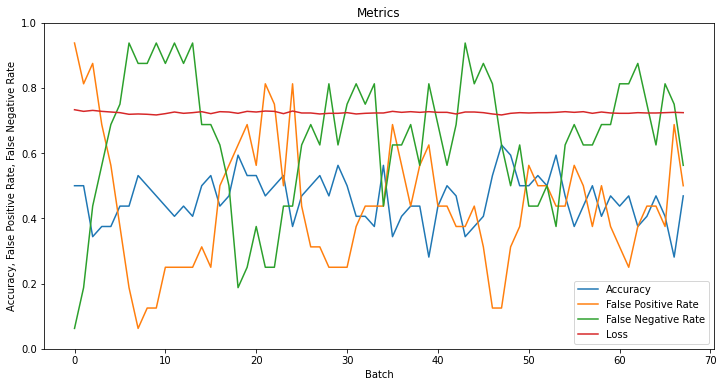

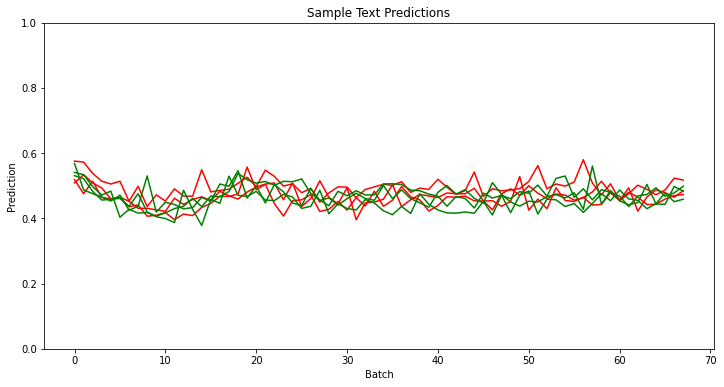

KeyboardInterrupt: ignored

In [260]:
## Experiment: adjusting the labels based on which are most commonly missed

for i in range(200):

  # If there are mostly false positive, feed the model a batch of negatives
  if precision > 0.66:
    _dataloader = dataloader_0

  # If there are some false positives and some false negatives, feed a 50-50 split
  elif precision > 0.33:
    _dataloader = dataloader

  # If there are mostly false negatives, feed the model all positives
  else:
    _dataloader = dataloader_1

  # Call one-epoch one-batch finetune
  finetune(_dataloader, model, loss_fn, optimizer, n_epochs = 1, max_iter = 1, eval_interval = 1)

  # Calculate precision from the last epoch
  precision = fp_list[-1] / (fp_list[-1] + fn_list[-1])


In [266]:
optimizer = optim.Adam(model.parameters(), lr = 0.00000001)

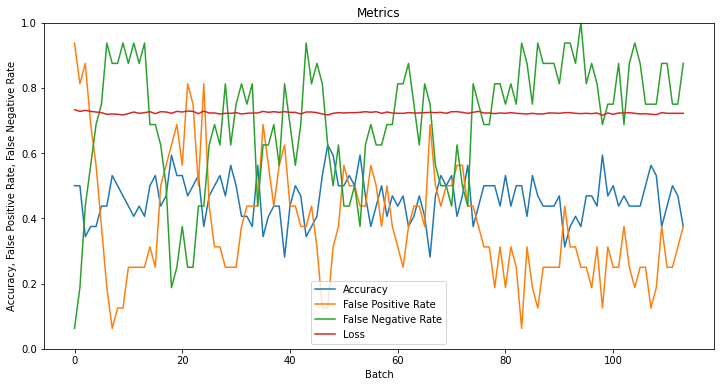

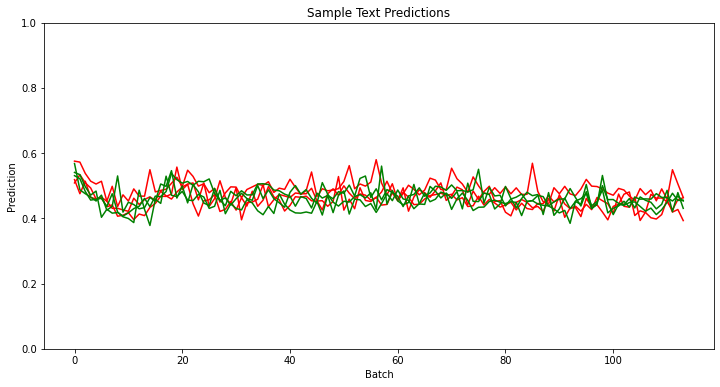

KeyboardInterrupt: ignored

In [267]:
## Normal finetune call
finetune(dataloader, model, loss_fn, optimizer)